In [24]:
import pandas as pd
import re
from unidecode import unidecode 
from spacy.lang.pt.stop_words import STOP_WORDS
from nltk.corpus import stopwords 
import nltk
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv('input/df.csv', sep = ",")
del df['Unnamed: 0']

In [34]:
def transform_text(tokens):
    # html transform
    tokens = tokens.replace('<div data-plugin="googleTranslate" id="lyrics">', '').replace('</div>', '').replace('<br/>', " ")
    # stop words
    stop_words_ = STOP_WORDS.union(stopwords.words('portuguese'))
    stop_words = [unidecode(stop).lower() for stop in stop_words_]
    # Split to translate
    tokens = tokens.split()
    # Concatenate
    tokens = ' '.join(tokens)
    # Remove accents
    tokens = unidecode(tokens)
    # Remove https, mentions, special characters, single character
    tokens = re.sub("(@[A-Za-z0-9]+)|(_[A-Za-z0-9]+)|(\w+:\/\/\S+)|(\W_)", " ", tokens).lower()
    # Remove pontuaction
    tokens = re.sub('['+string.punctuation+']', '', tokens)
    # Substituting multiple spaces with single space
    tokens = re.sub(r'\s+', ' ', tokens, flags=re.I)
    # Remove digits
    tokens = ''.join([i for i in tokens if not i.isdigit()])
    # Remove all single characters
    tokens = re.sub(r'\s+[a-zA-Z]\s+', ' ', tokens)
    # Split
    tokens = tokens.split()
    # Stopwords
    tokens = [w for w in tokens if w not in stop_words]
    # Concatenate
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

In [35]:
%%time
df['Transformed'] = df['lyrics'].apply(lambda x: transform_text(x))

CPU times: user 15 s, sys: 2.14 s, total: 17.2 s
Wall time: 18.8 s


In [36]:
df['Transformed'].head()

0    dirigir beba beber chame irmao saia rotina cai...
1    andei pensando espelho deixar manda deixar lag...
2    uo uo uoo uoooo hoje night promete to madrugad...
3    ficar tentando sai cabeca escutar entender dei...
4    esquecer mudou balancou invadiu vida facil pen...
Name: Transformed, dtype: object

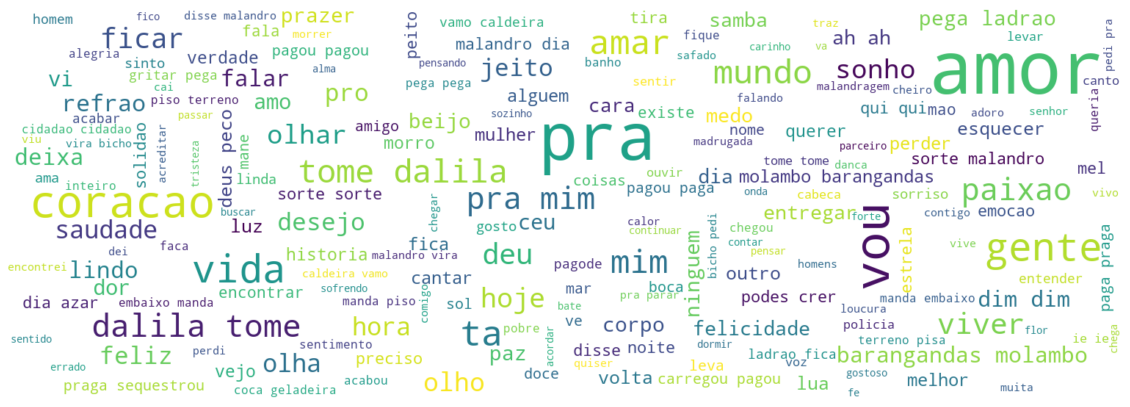

In [46]:
plt.figure(figsize = (20,20)) 
text = " ".join(review for review in df[df['category'] == 'Pagode']['Transformed'])
wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show()

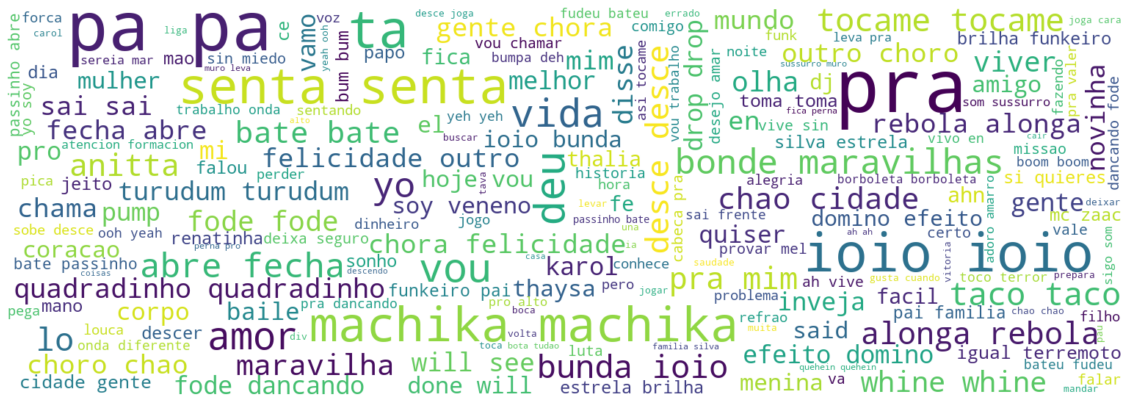

In [49]:
plt.figure(figsize = (20,20)) 
text = " ".join(review for review in df[df['category'] == 'Funk Carioca']['Transformed'])
wordcloud = WordCloud(max_font_size=100,width = 1520, height = 535, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show()